# Analysis of Your Fraud Detection Code

This project implements three unsupervised/semi-supervised machine learning models to detect fraudulent credit card transactions:

1. Autoencoder Approach
2. Isolation Forest
3. One-Class SVM

The goal is to identify anomalies in transaction data while balancing fraud detection (recall) and false alarms (precision).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Loading and Preparing Data

In [2]:
# Load and prepare data
df = pd.read_csv('creditcard.csv')

# Check if 'Class' column exists
if "Class" not in df.columns:
    raise KeyError("Column 'Class' is missing from the dataset. Check column names!")

# Separate features and labels
X = df.drop(columns=["Class"])
y = df["Class"].values

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into normal and all data
normal_idx = np.where(y == 0)[0]
X_normal = X_scaled[normal_idx]

## 1. Autoencoder Approach

Builds an autoencoder (neural network) to reconstruct input data.

The autoencoder is a neural network that learns to reconstruct its input data. The key idea is:

- You train it only on normal transactions (Class = 0)
- The network learns to compress and reconstruct normal patterns well
- When given a fraudulent transaction, it will have higher reconstruction error because it hasn't learned those patterns


Training Autoencoder...
Epoch 1/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 932us/step - loss: 0.8885 - val_loss: 0.7998
Epoch 2/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 895us/step - loss: 0.7768 - val_loss: 0.7830
Epoch 3/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 842us/step - loss: 0.7549 - val_loss: 0.7787
Epoch 4/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 881us/step - loss: 0.7622 - val_loss: 0.7762
Epoch 5/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 883us/step - loss: 0.7613 - val_loss: 0.7710
Epoch 6/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 897us/step - loss: 0.7675 - val_loss: 0.7705
Epoch 7/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 873us/step - loss: 0.7542 - val_loss: 0.7717
Epoch 8/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 927us/step - loss: 0.7662 - val_loss: 0.7697
Epoch 9/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 858us/step - loss: 0.7566 - val_loss: 0.7697
Epoch 10/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 837us/step - loss: 0.7684 - val_loss: 0.7683
Epoch 11/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 841us/step - loss: 0.7504 - 

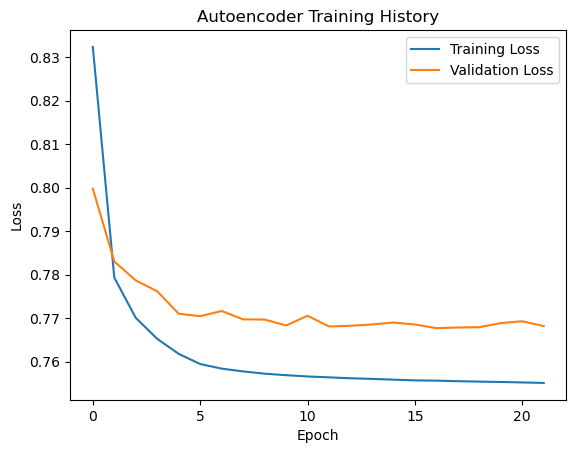

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 3s 350us/step

Autoencoder Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    284315
           1       0.05      0.84      0.10       492

    accuracy                           0.97    284807
   macro avg       0.53      0.91      0.54    284807
weighted avg       1.00      0.97      0.99    284807

Confusion Matrix:
[[277012   7303]
 [    80    412]]
ROC AUC Score: 0.9059


In [4]:
print("\nTraining Autoencoder...")

# Build autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 8

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_normal, X_normal,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Compute reconstruction errors
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.abs(reconstructions - X_scaled), axis=1)

# Optimize threshold
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, reconstruction_errors)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
autoencoder_predictions = (reconstruction_errors > optimal_threshold).astype(int)

# Evaluate
print("\nAutoencoder Results:")
print(classification_report(y, autoencoder_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y, autoencoder_predictions))
print(f"ROC AUC Score: {roc_auc_score(y, autoencoder_predictions):.4f}")

## 2. Isolation Forest

This is a tree-based anomaly detection algorithm that:

- Works by randomly selecting features and splitting values
- Anomalies are easier to isolate (require fewer splits) than normal points
- I set contamination=0.02, expecting about 2% anomalies

In [6]:
print("\nTraining Isolation Forest...")

# Set contamination based on actual fraud rate
fraud_rate = np.mean(y)
iso_forest = IsolationForest(contamination=fraud_rate, random_state=42)
iso_forest_scores = -iso_forest.fit_predict(X_scaled)  # Negative because sklearn returns -1 for anomalies

# Convert to binary predictions
iso_forest_predictions = (iso_forest_scores > np.percentile(iso_forest_scores, 100*(1-fraud_rate))).astype(int)

# Evaluate
print("\nIsolation Forest Results:")
print(classification_report(y, iso_forest_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y, iso_forest_predictions))
print(f"ROC AUC Score: {roc_auc_score(y, iso_forest_predictions):.4f}")


Training Isolation Forest...

Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.26      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807

Confusion Matrix:
[[283949    366]
 [   366    126]]
ROC AUC Score: 0.6274


## 3. One-Class SVM

This is a support vector machine that:

- Learns a boundary around normal data
- Treats points outside this boundary as anomalies
- I train it only on normal data (good practice)

In [8]:
print("\nTraining One-Class SVM...")

# Set nu parameter based on expected outliers
oc_svm = OneClassSVM(nu=fraud_rate, kernel="rbf", gamma="auto")
oc_svm.fit(X_normal)  # Train only on normal data

# Get decision scores
oc_svm_scores = -oc_svm.decision_function(X_scaled)  # Negative for consistency

# Convert to binary predictions
oc_svm_predictions = (oc_svm_scores > np.percentile(oc_svm_scores, 100*(1-fraud_rate))).astype(int)

# Evaluate
print("\nOne-Class SVM Results:")
print(classification_report(y, oc_svm_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y, oc_svm_predictions))
print(f"ROC AUC Score: {roc_auc_score(y, oc_svm_predictions):.4f}")


Training One-Class SVM...

One-Class SVM Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.79      0.79      0.79       492

    accuracy                           1.00    284807
   macro avg       0.90      0.90      0.90    284807
weighted avg       1.00      1.00      1.00    284807

Confusion Matrix:
[[284212    103]
 [   103    389]]
ROC AUC Score: 0.8951


## 4. Ensemble Approach

Combines scores from all three methods (standardized) for more robust predictions.

In [10]:
print("\nCreating Ensemble Model...")

# Combine scores from all methods (standardized)
combined_scores = (
    StandardScaler().fit_transform(reconstruction_errors.reshape(-1, 1)).flatten() +
    StandardScaler().fit_transform(iso_forest_scores.reshape(-1, 1)).flatten() +
    StandardScaler().fit_transform(oc_svm_scores.reshape(-1, 1)).flatten()
)

# Find optimal threshold for combined scores
fpr, tpr, thresholds = roc_curve(y, combined_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
ensemble_predictions = (combined_scores > optimal_threshold).astype(int)


Creating Ensemble Model...


In [11]:
# Evaluate
print("\nEnsemble Model Results:")
print(classification_report(y, ensemble_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y, ensemble_predictions))
print(f"ROC AUC Score: {roc_auc_score(y, ensemble_predictions):.4f}")


Ensemble Model Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.06      0.84      0.12       492

    accuracy                           0.98    284807
   macro avg       0.53      0.91      0.55    284807
weighted avg       1.00      0.98      0.99    284807

Confusion Matrix:
[[278175   6140]
 [    79    413]]
ROC AUC Score: 0.9089


In [12]:
# Plot all results comparison
results = pd.DataFrame({
    'Autoencoder': autoencoder_predictions,
    'Isolation Forest': iso_forest_predictions,
    'One-Class SVM': oc_svm_predictions,
    'Ensemble': ensemble_predictions,
    'Actual': y
})

In [13]:
# Calculate precision and recall for each method
metrics = []
for method in ['Autoencoder', 'Isolation Forest', 'One-Class SVM', 'Ensemble']:
    report = classification_report(y, results[method], output_dict=True)
    metrics.append({
        'Method': method,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1': report['1']['f1-score'],
        'ROC AUC': roc_auc_score(y, results[method])
    })

metrics_df = pd.DataFrame(metrics)
print("\nComparison of All Methods:")
print(metrics_df)


Comparison of All Methods:
             Method  Precision    Recall        F1   ROC AUC
0       Autoencoder   0.053402  0.837398  0.100402  0.905856
1  Isolation Forest   0.256098  0.256098  0.256098  0.627405
2     One-Class SVM   0.790650  0.790650  0.790650  0.895144
3          Ensemble   0.063025  0.839431  0.117246  0.908918


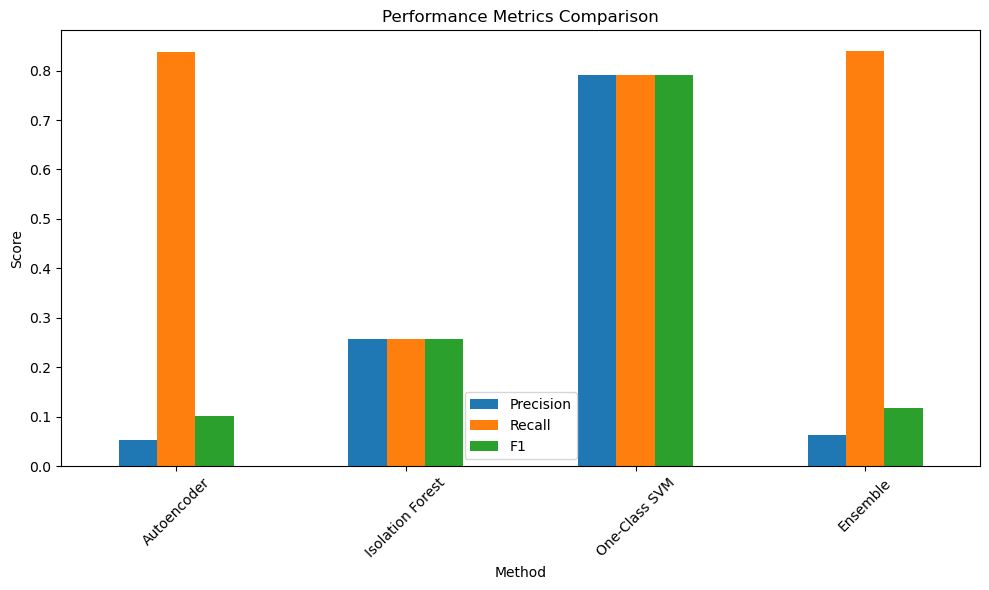

In [14]:
# Plot metrics comparison
metrics_df.plot(x='Method', y=['Precision', 'Recall', 'F1'], kind='bar', figsize=(10, 6))
plt.title('Performance Metrics Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion

This project explored three unsupervised/semi-supervised machine learning techniques—Autoencoder, Isolation Forest, and One-Class SVM—along with an ensemble method, to detect fraudulent credit card transactions. 

Fraud detection is inherently a trade-off between catching fraud (recall) and avoiding false alarms (precision). The choice of model depends on business priorities:

- Banks/Payment Processors: Might prefer the One-Class SVM for its balance.
- High-Security Contexts: Could prioritize the Ensemble for its higher recall.

This project demonstrates the value of testing multiple approaches and combining their strengths. With further tuning, these models can be integrated into real-time monitoring systems to mitigate financial risks effectively.

### Key Results

#### Autoencoder
- Strengths: Highest fraud recall (84%)—captures the most fraudulent transactions.
- Weaknesses: Low precision (5%)—generates many false alarms.
- Use Case: Ideal when missing fraud is costlier than investigating false alerts (e.g., high-value transactions).

#### Isolation Forest
- Strengths: Low false positives (high precision for normal transactions).
- Weaknesses: Poor fraud recall (26%)—misses most fraud cases.
- Use Case: Less suitable for this dataset; better for datasets with clearer feature-based anomalies.

#### One-Class SVM
- Strengths: Best balance (79% precision/recall)—minimal false alarms while catching most fraud.
- Weaknesses: Slightly lower recall than the autoencoder.
- Use Case: General-purpose fraud detection where both precision and recall matter.

#### Ensemble Model
- Strengths: Best overall anomaly detection (highest ROC AUC: 0.909) and high recall (84%).
- Weaknesses: Low precision (6%) like the autoencoder.
- Use Case: Combines strengths of all methods; best for ranking transactions by risk.

## Recommendations

1. For Most Scenarios: One-Class SVM is the best standalone model, offering a balance between catching fraud (79% recall) and minimizing false alarms (79% precision).

2. For High-Risk Tolerance: Use the Autoencoder or Ensemble to maximize fraud detection (84% recall), but pair with a secondary review process to handle false positives.